In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn 
import matplotlib.pyplot as plt
import shap
import joblib
#from models.jm_lstm_template import simpleLSTM
from captum.attr import GradientShap
from utils.utils import MLP_FEATURES


In [3]:
class MLP(nn.Module):
    def __init__(self, hidden_size=5, dropout=.30, input_dim=60, output_dim=1):
        super(MLP, self).__init__()

        # init the params
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.input_dim = input_dim
        self.output_dim = output_dim

        # init the layers
        self.fc1 = nn.Linear(self.input_dim, self.hidden_size)
        self.fc2 = nn.Linear(self.hidden_size, self.output_dim)

        # dorp out on the first two layers only?
        self.dropOut1 = nn.Dropout(p=self.dropout)
        self.dropOut2 = nn.Dropout(p=self.dropout)
    
    def forward(self, inputs):
        # roll through model
        outputs = self.dropOut1(torch.tanh(self.fc1(inputs)))
        outputs = self.dropOut2(torch.tanh(self.fc2(outputs)))
        #print('Size of Outputs', outputs.shape)
        return outputs

In [4]:
# inputs
#model_path = 'lstm_base.pt'
model_path = r'C:\Users\jaman\OneDrive\CS7643\class_project\deep_momentum_networks\model.pt'
device = torch.device('cuda')
xtest_name = r'C:\Users\jaman\OneDrive\CS7643\class_project\deep_momentum_networks\xtest_L3Y.pkl'
xtest = pd.read_pickle(xtest_name)
xtest = xtest.to_numpy()
col_names = MLP_FEATURES
model_type = 'mlp'

# load the model with the last best current weights
if model_type == 'mlp':
    model = MLP(hidden_size=20,
                dropout=.20,
                input_dim=48)
    model.load_state_dict(torch.load(model_path))
    model.to(device)

if model_type == 'lstm':
    model = simpleLSTM(hidden_dim=20,
                       dropout_rate=.20,
                       input_dim=8)
    model.load_state_dict(torch.load(model_path))
    
#####################################################
if isinstance(xtest, np.ndarray):
    xtest = torch.tensor(xtest,
                         dtype=torch.float32,
                         device=device,
                         requires_grad=True)

# explainer
explainer = GradientShap(model)
baselines = torch.zeros(xtest.shape,
                        device=device,
                        dtype=torch.float32)

print(xtest.shape)


attribution = explainer.attribute(xtest, baselines)

if model_type == 'lstm':
    attribution = attribution[:, -1, :]
    xtest = xtest[:, -1, :]

# store a numpy example as well
xtest2 = xtest.cpu().detach().numpy()


torch.Size([63144, 48])


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


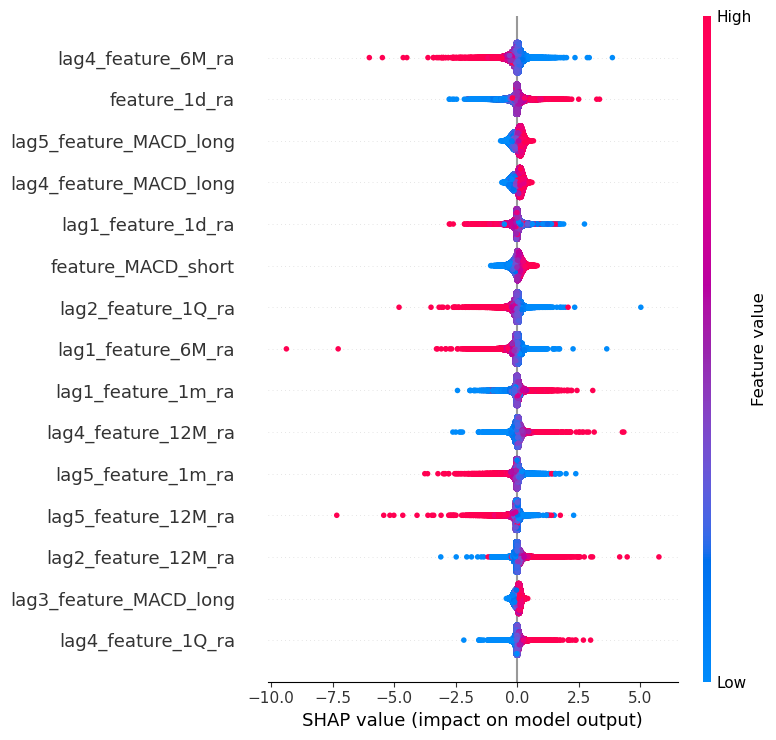

In [5]:
# let's show the basic shape summary plot
attribution = attribution.cpu().detach().numpy()
shap.summary_plot(attribution, xtest2, feature_names=col_names, max_display=15)

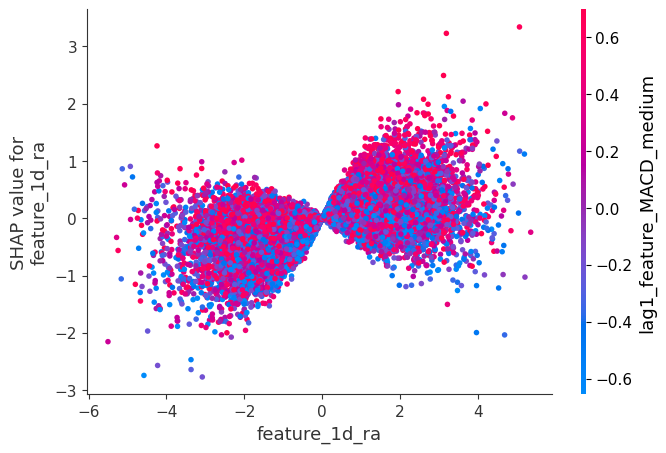

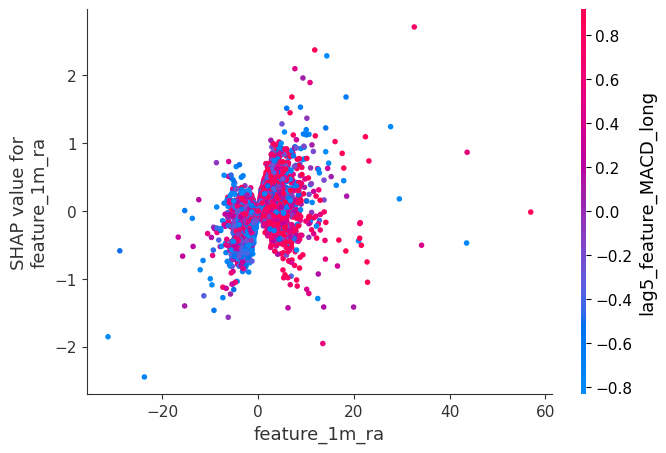

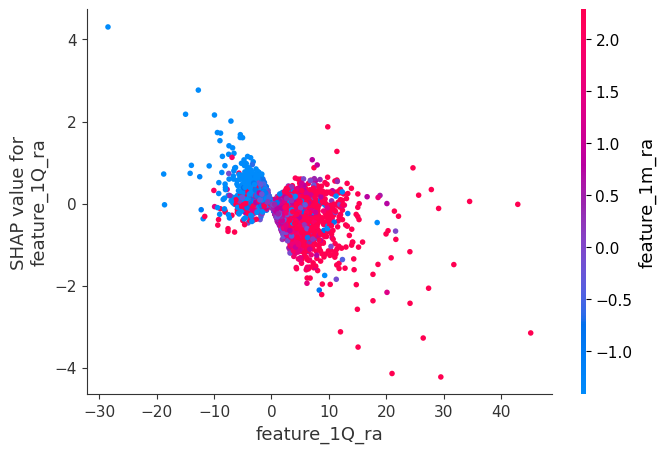

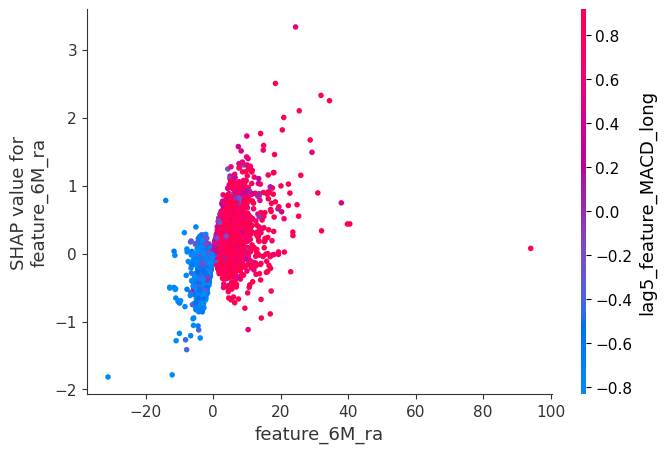

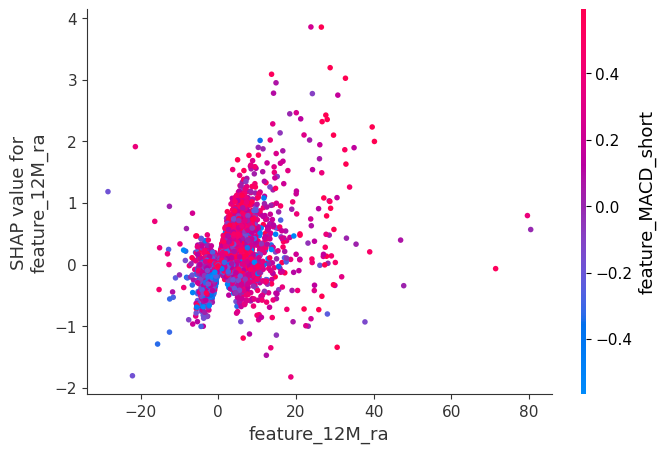

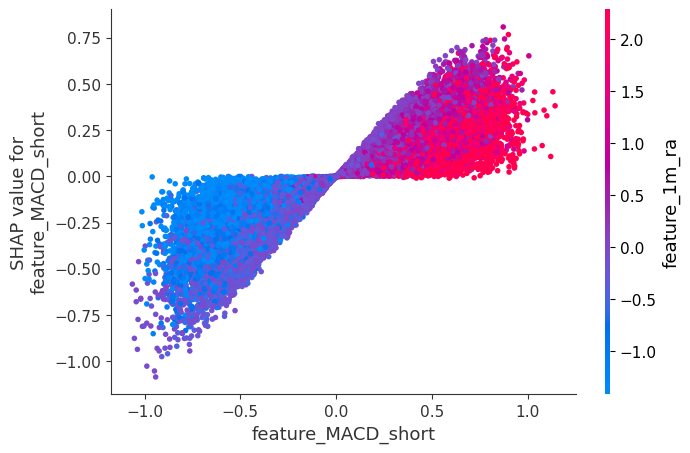

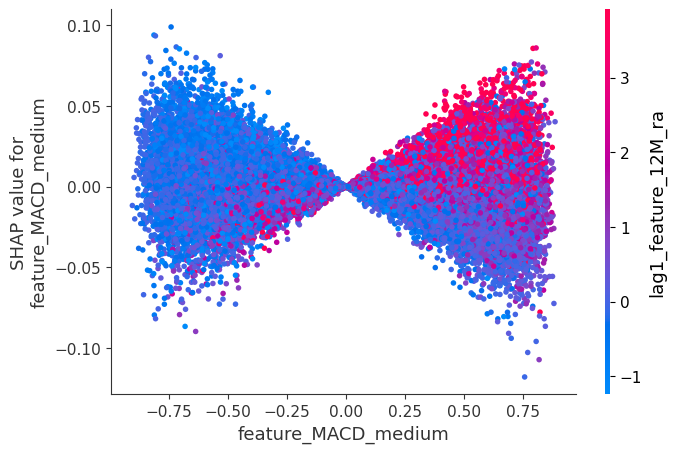

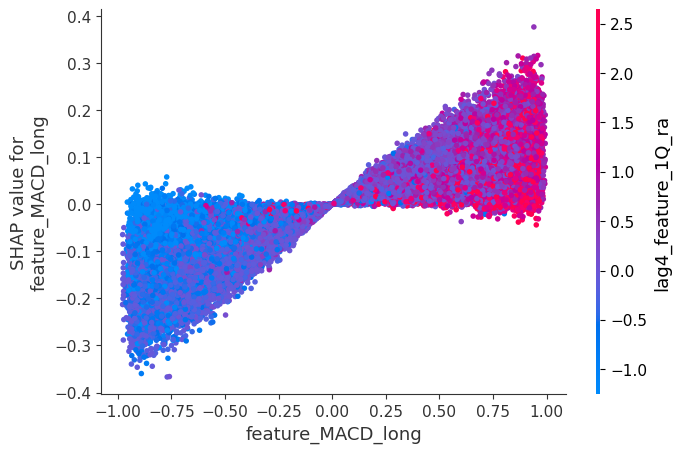

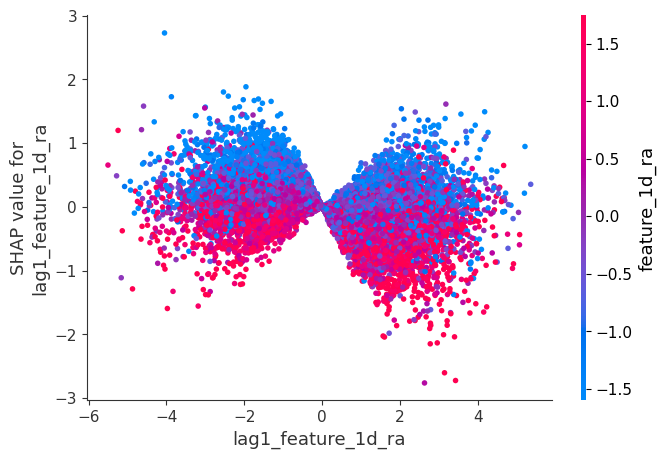

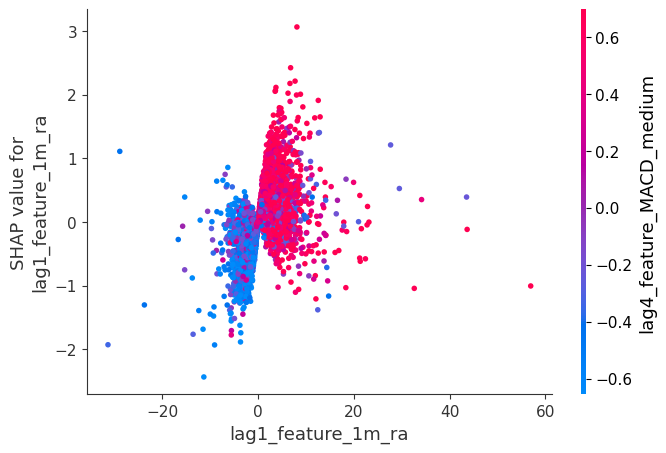

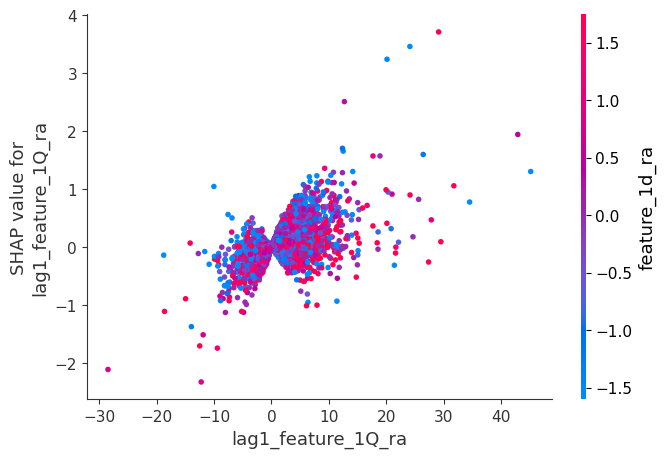

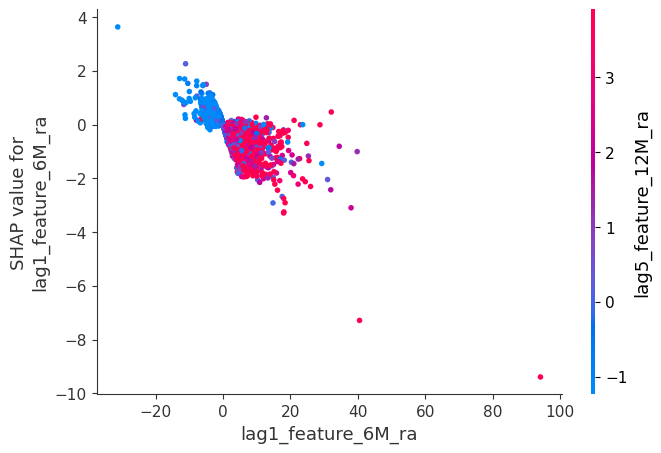

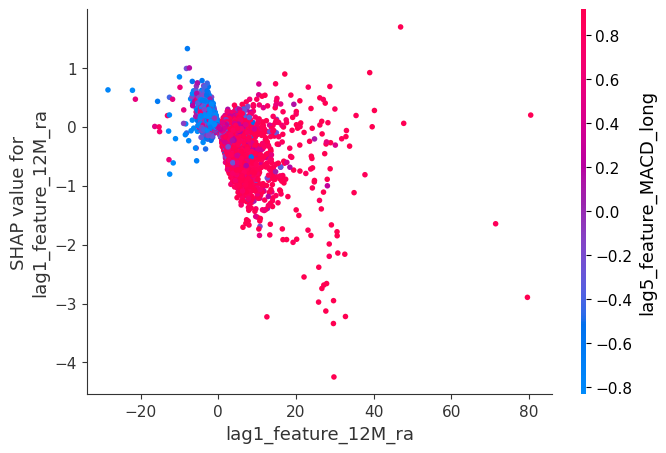

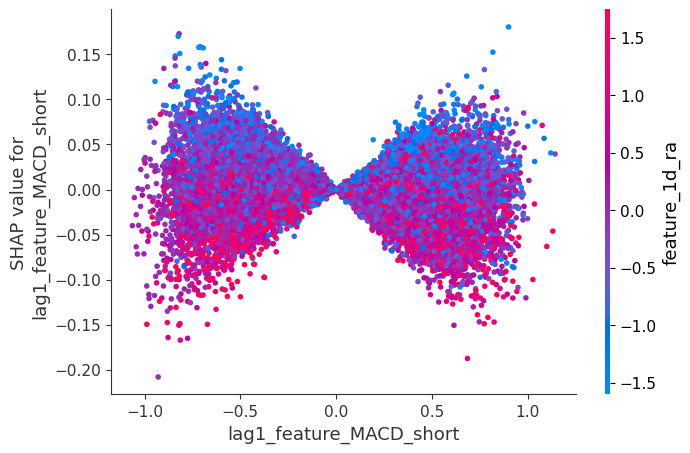

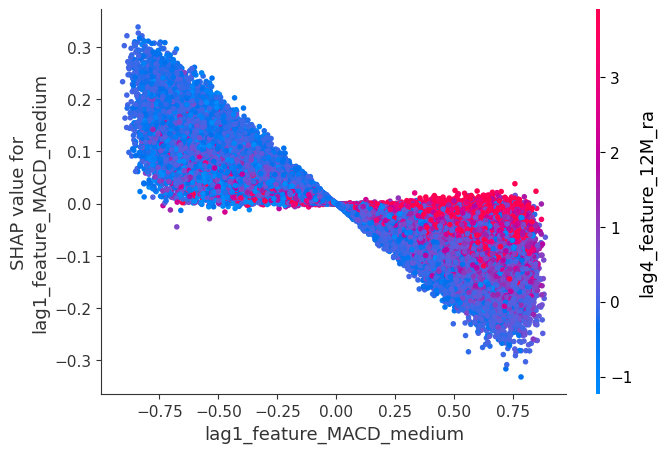

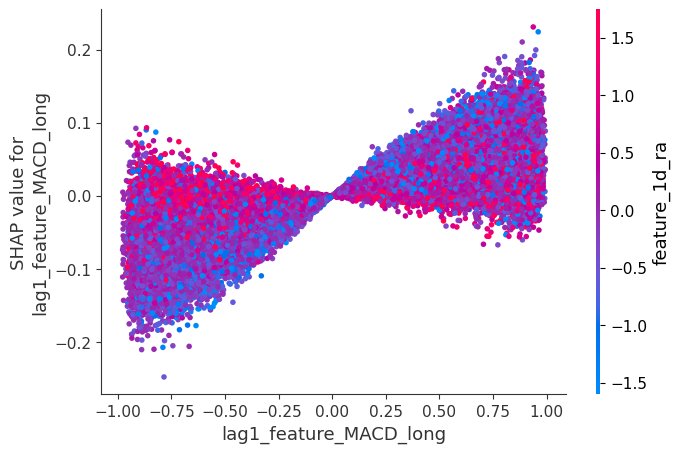

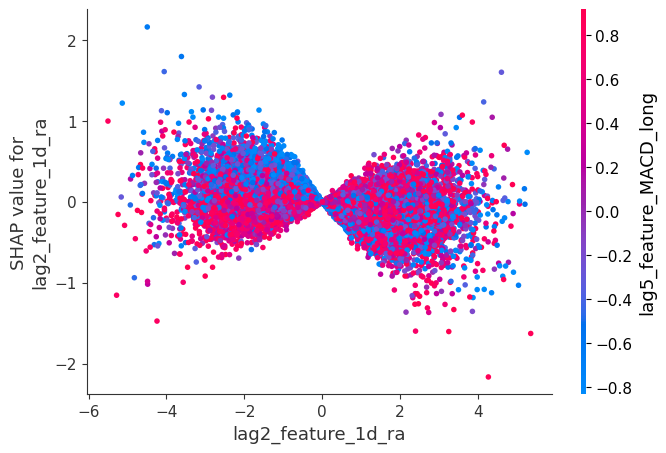

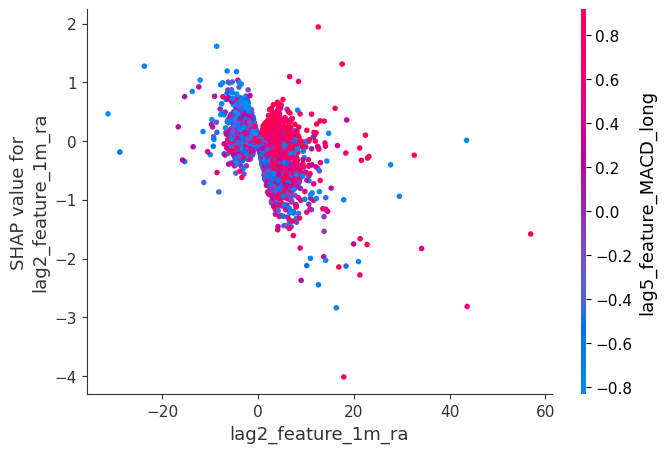

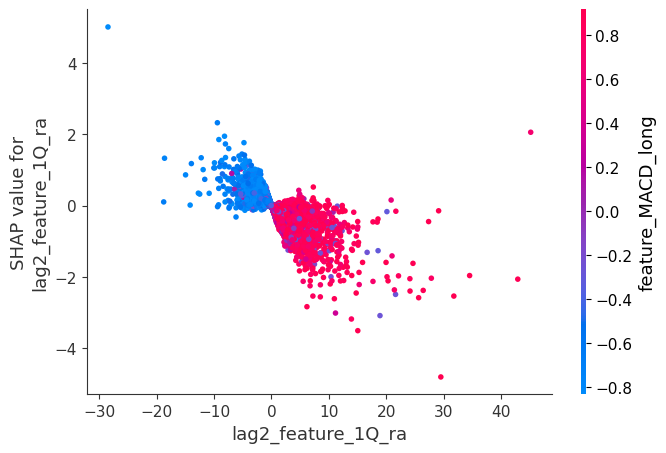

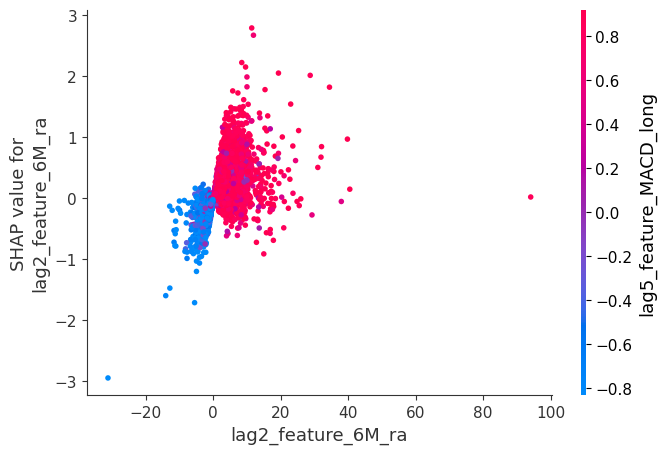

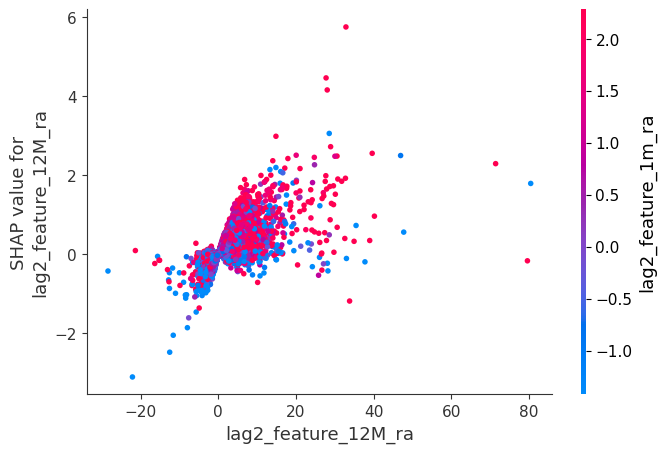

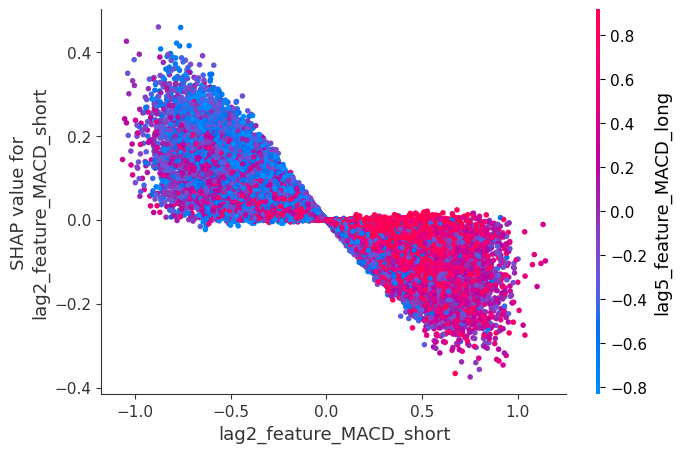

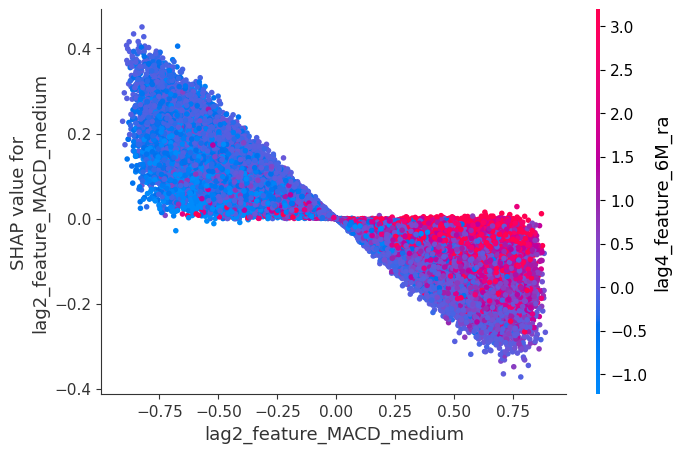

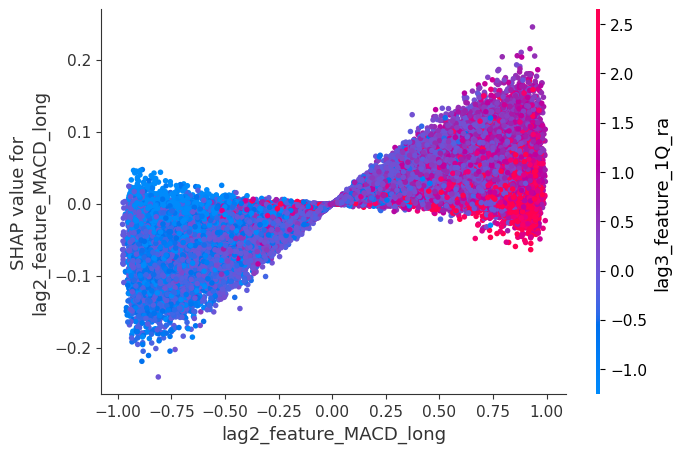

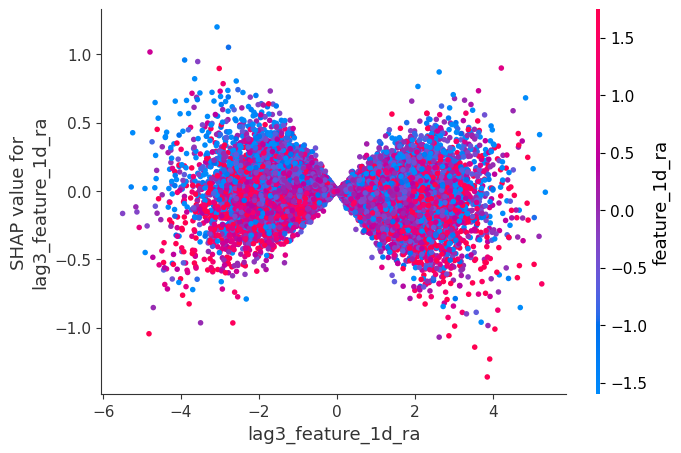

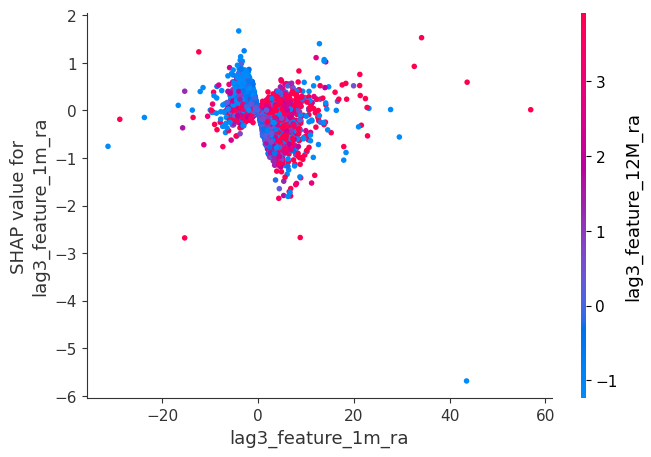

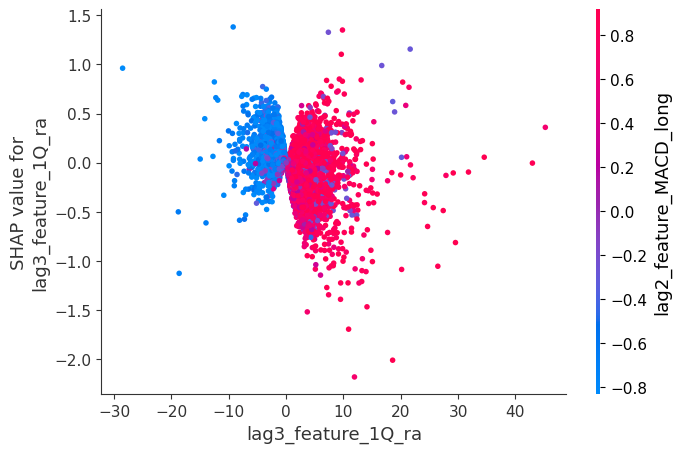

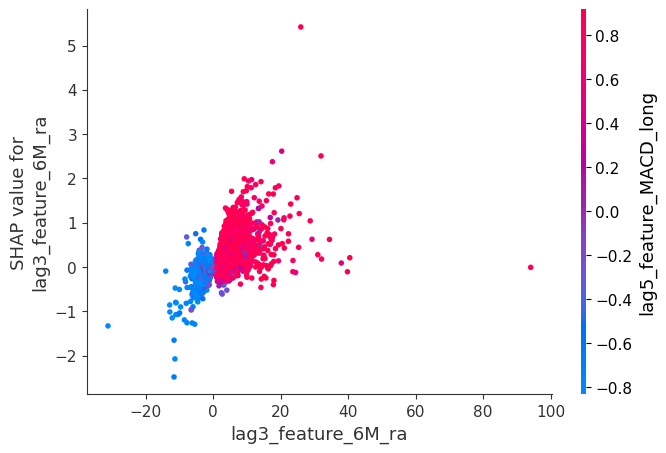

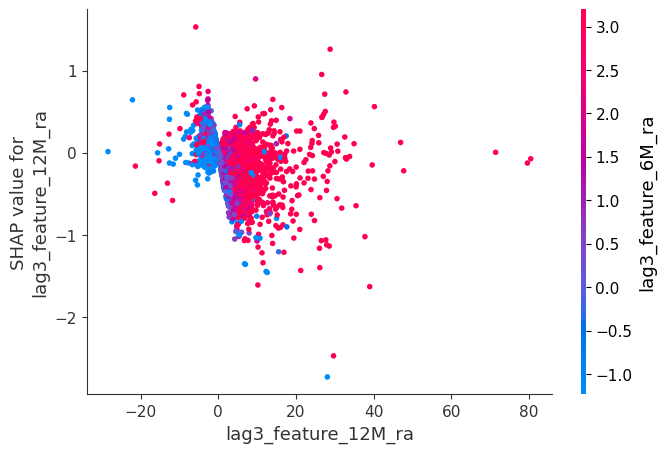

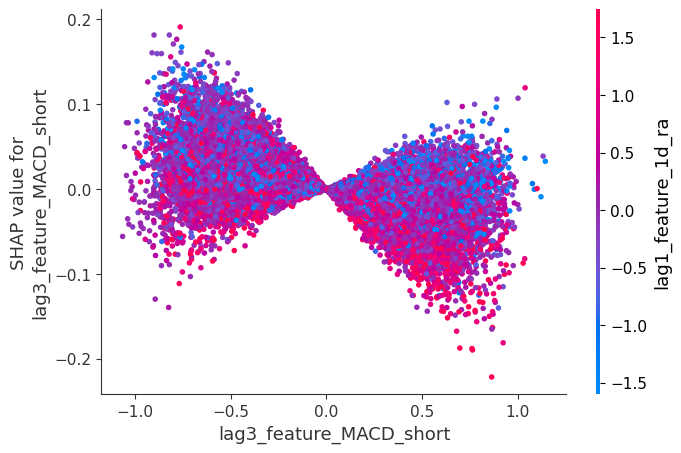

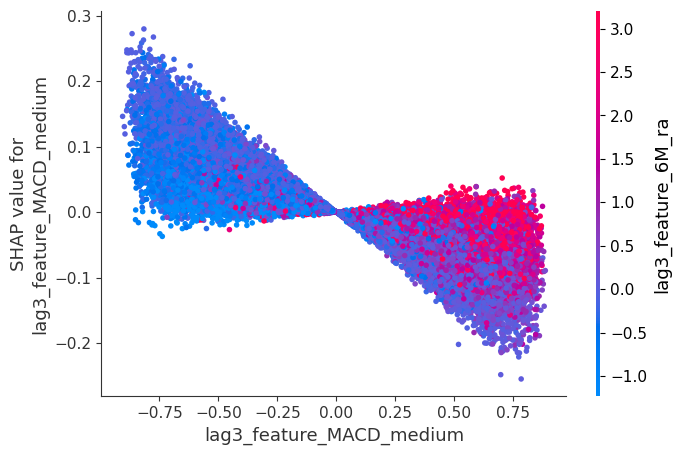

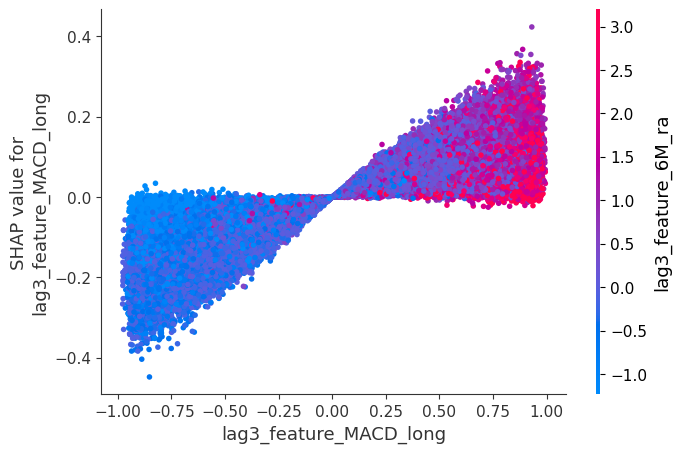

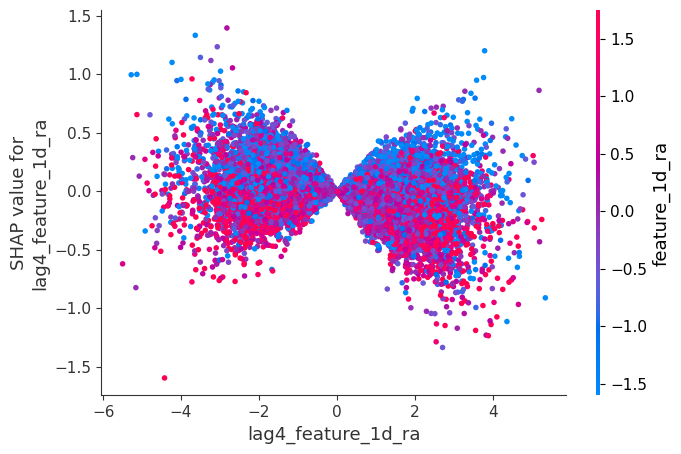

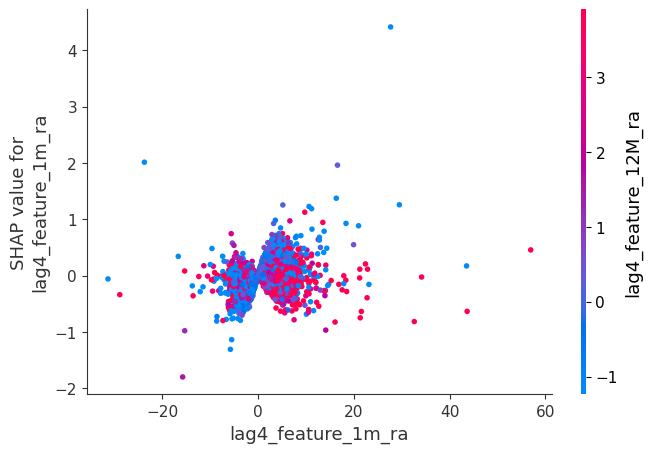

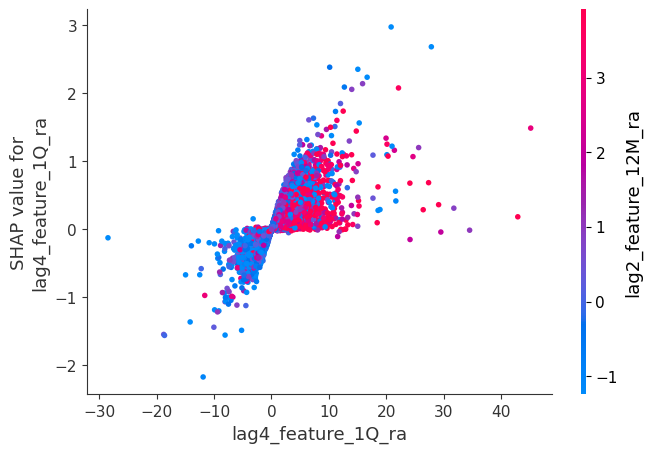

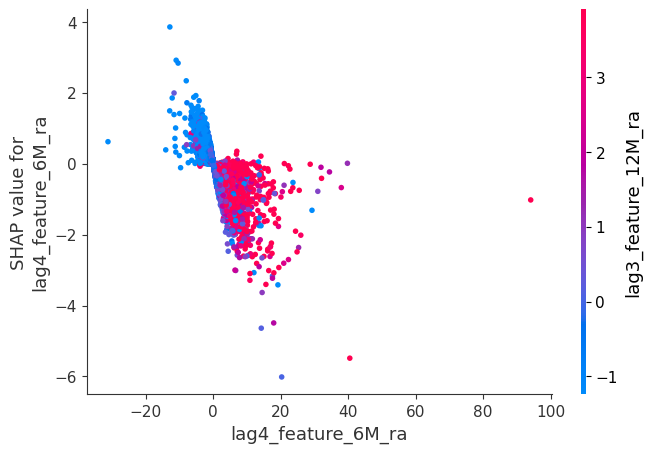

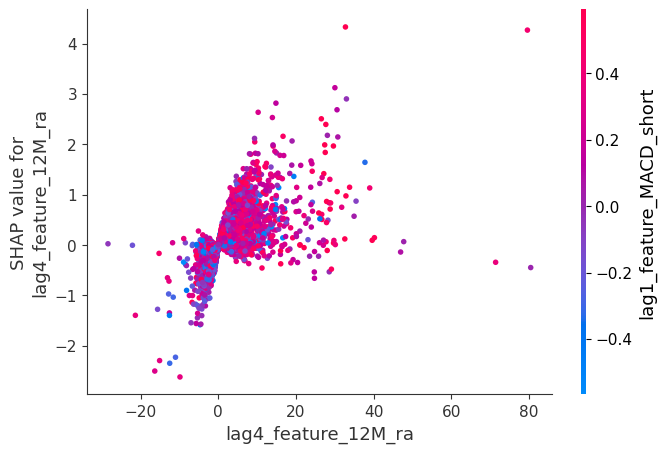

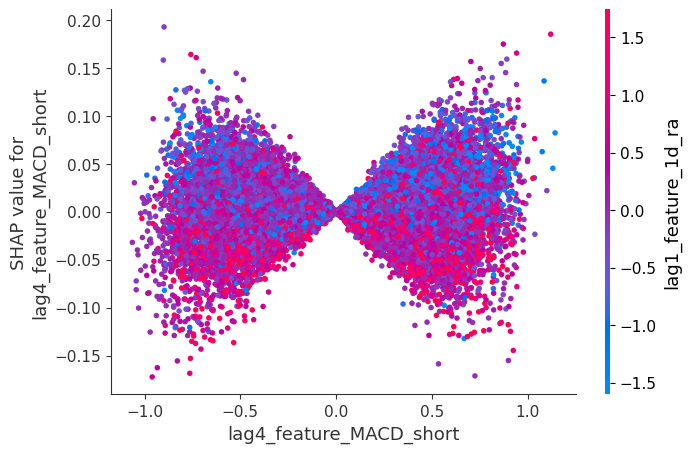

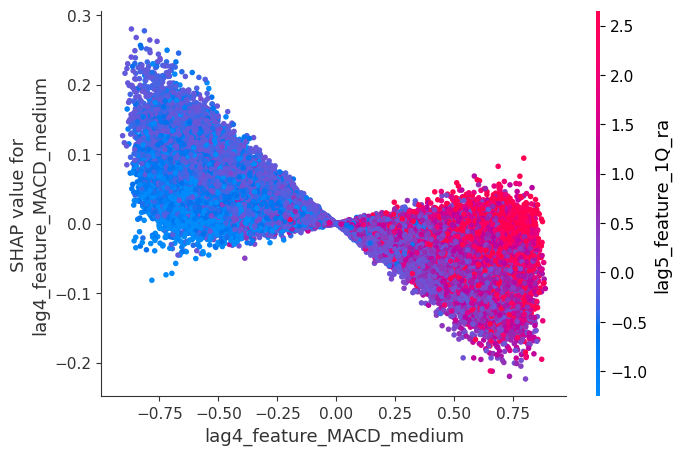

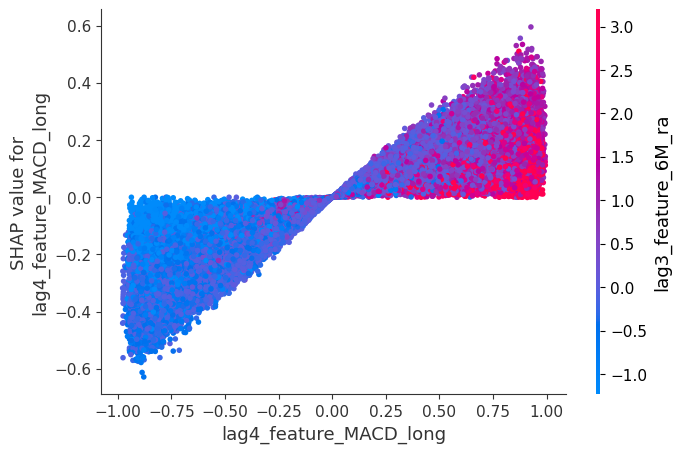

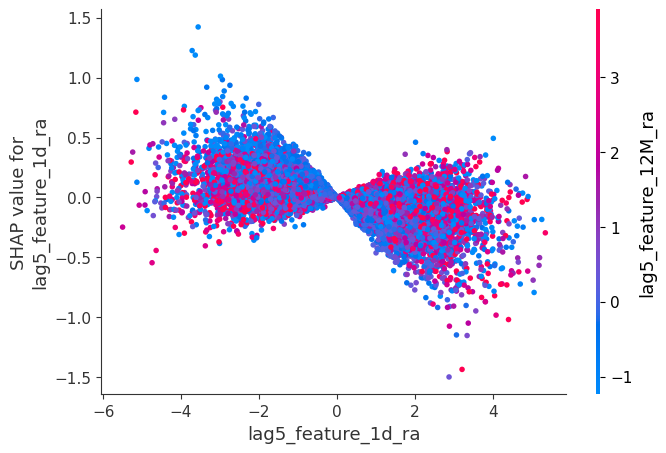

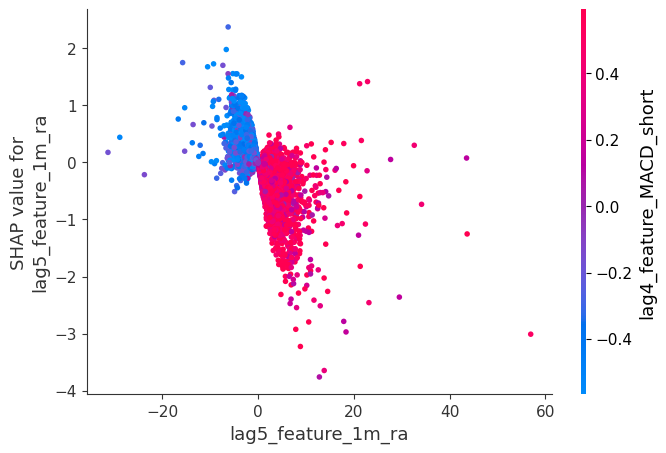

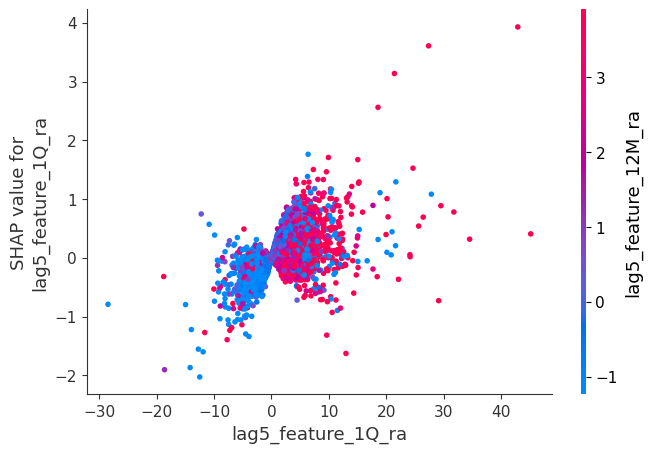

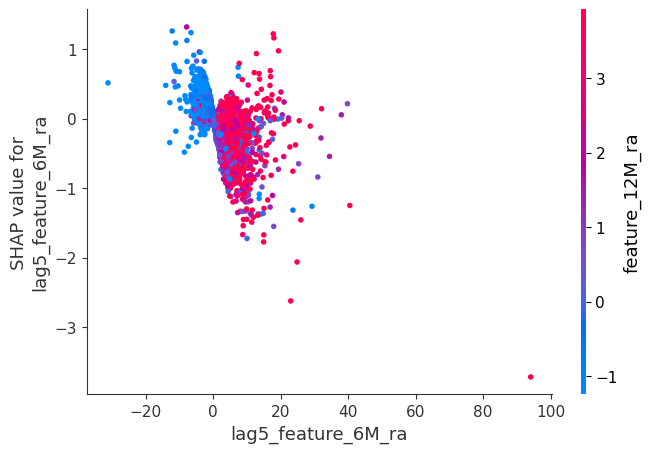

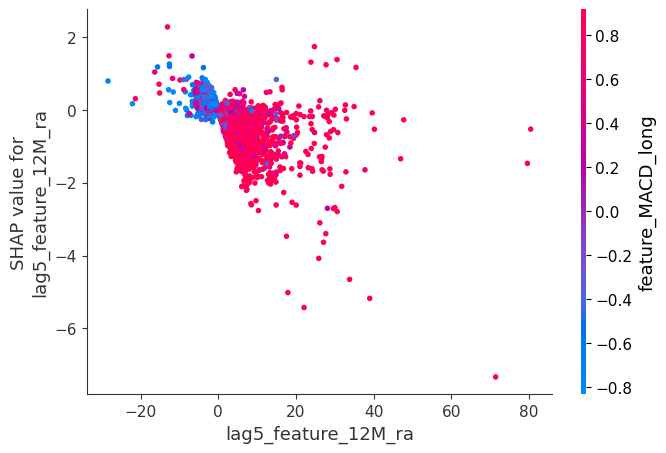

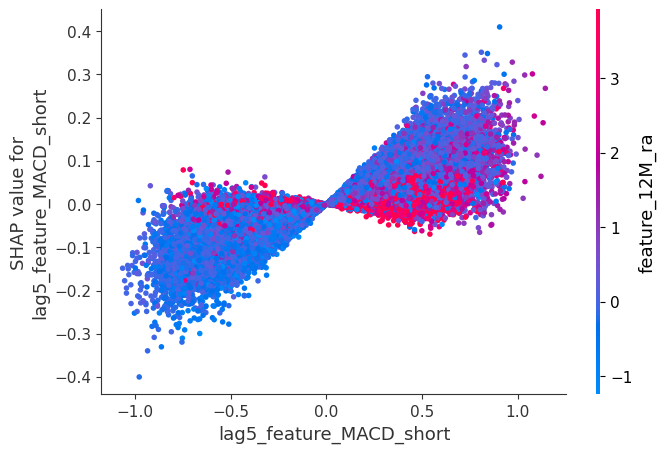

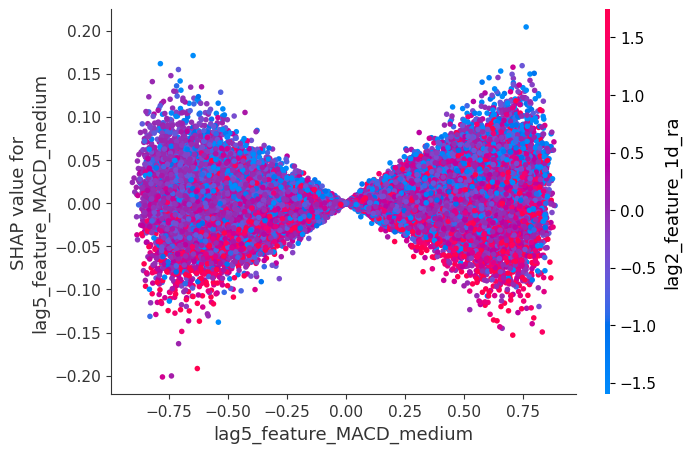

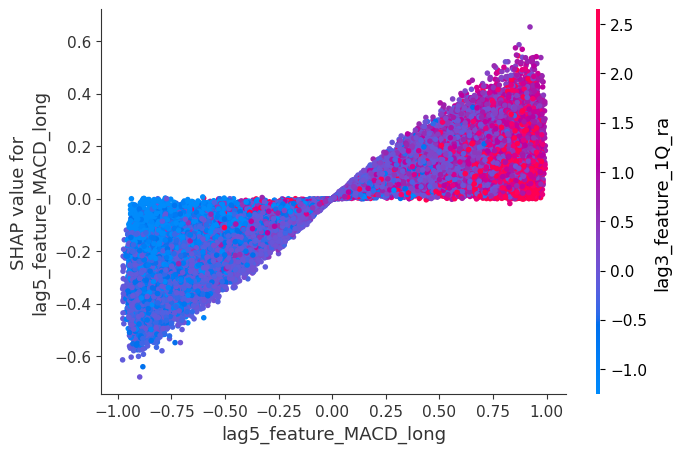

In [6]:
# loop through and show the SHAP dependence plot
for col in col_names:
    shap.dependence_plot(col,
                         attribution,
                         xtest2,
                         feature_names=col_names)